## Exercise

1. Download the bone marrow / leukemia gene expression ן dataset (leukemia_small.csv) from https://web.stanford.edu/~hastie/CASI_files/DATA/leukemi a.html
2. Apply consensus hierarchical clustering and sparse NMF ן clustering to these patient data with k =2 clusters
3. Compare both clustering results in terms of cluster purity ן for AML and ALL patient groups. 

Author: Shreya Kapoor

In [1]:
import scipy
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster
import seaborn as sns
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import sys
from datetime import date



In [37]:
def make_dendogram(D, cells, method, metric): 
    
    Z = linkage(D, method= method, metric = metric) 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    plt.subplots_adjust(left=0.07, bottom=0.3, right=0.98, top=0.95,
    wspace=0, hspace=0)
    plt.xlabel('Cell Line')
    plt.ylabel('Distance')
    den = dendrogram(Z, leaf_font_size=10., labels = cells)
    return Z, den 

In [38]:
def make_mnh(Z, k, cells, d, df): 
    clusters = cut_tree(Z, k) #this helps us get the cluster number of each index. 
    #clusters = cut_tree(Z, n_clusters = 2)
    #print(clusters)
    dic = { cells[i] :clusters[i][0]  for i in range(len(clusters))}
    # we make the dictionary in order to determine for which columns we got the clusters that we did
    Mh = np.zeros((df.shape[1], df.shape[1]))
    Ih = np.zeros((df.shape[1], df.shape[1]))
    for i in range(df.shape[1]): #since we are clustering along cells
            for j in range(df.shape[1]): 
                  if df.columns[i] in d.columns: 
                        if df.columns[j] in d.columns: 
                              Ih[i][j] = 1 
                  #FINDING IF INDEXES I AND J BELONG TO THE SAME CLUSTER OR NOT. 
                  if df.columns[i] in dic.keys() and df.columns[j] in dic.keys(): 
                          if dic[df.columns[i]] == dic[df.columns[j]]: 
                                Mh[i][j] = 1
    return Mh, Ih

In [39]:
df = pd.read_csv('leukemia_small.csv')

In [40]:
df = df.reindex(sorted(df.columns), axis=1)

In [41]:
df.head()

,ALL,ALL.1,ALL.10,ALL.11,ALL.12,ALL.13,ALL.14,ALL.15,ALL.16,ALL.17,...,AML.22,AML.23,AML.24,AML.3,AML.4,AML.5,AML.6,AML.7,AML.8,AML.9
0,0.561549,-0.623141,-0.425078,0.073160,-0.586642,-0.668417,-0.632941,1.000113,-1.002407,-0.286922,...,-0.940462,-0.207155,0.062535,-0.392025,-0.772689,-0.838850,-0.577849,-0.361472,-0.689056,-0.572561
1,0.213566,-0.912107,1.443450,-0.286462,0.548776,-0.735544,-0.920912,-0.955369,-0.360956,-0.610005,...,-0.429690,-0.538333,-0.296009,-0.704443,-0.071978,0.824360,-0.871411,1.014612,-0.971334,1.253959
2,-0.636584,-0.465296,-0.266910,0.232140,-0.428738,-0.510645,2.899624,-0.513522,-0.845180,-0.128529,...,-0.783134,-0.048632,0.221498,-0.233803,-0.615088,4.848568,-0.419930,-0.203200,0.856071,4.321011
3,0.347124,-0.734345,-0.819089,-0.308939,0.389220,0.177846,2.935376,-0.799112,0.396926,-0.677630,...,-1.346795,-0.595956,-0.319818,-0.785246,-0.768358,4.139257,0.225747,-0.753962,0.420346,2.993526
4,0.545509,-0.539898,-1.186585,-1.679732,0.576774,1.853739,1.879105,0.320799,0.060844,0.400633,...,-0.664693,-0.936764,-0.345593,-0.983114,-0.270606,3.065135,-0.656098,-0.327707,0.139299,1.480559


In [42]:
#rows are genes 
#columns are denoting the class labels

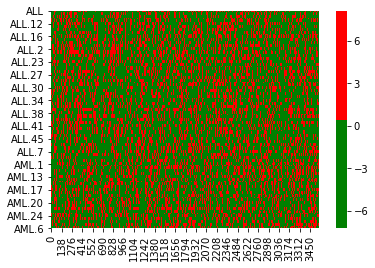

In [43]:
sns.heatmap(df.transpose() , cmap = ['green', 'red'])

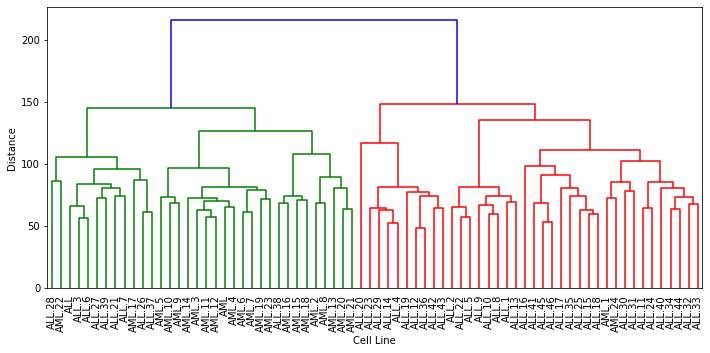

In [44]:
cells = list(df.columns.values) 
    #red is higher value and green is lower value 
D = df.values
cells = list(df.columns.values) 
if len(cells) != len(D):
        #scipy clusters the rows and not the columns
        #print ('transpose')
        D = np.transpose(D)
Z,den = make_dendogram(D, cells, 'ward', 'euclidean')

Main loop for getting the consensus matrix M

In [10]:
M = np.zeros((df.shape[1], df.shape[1]))
I = np.zeros((df.shape[1], df.shape[1]))
H = 1000 #Number of subsamples that we want!
for h in range(H): 
    d = df.sample(n = int(0.8*df.shape[1]) , axis = 1, random_state = h) #subsampling the columns
    cells = list(d.columns.values) 
    #red is higher value and green is lower value 
    D = d.values
    if len(cells) != len(D):
        #print ('transpose')
        D = np.transpose(D)

    Z = linkage(D, method='ward', metric='euclidean')
    #make the Mh matrix
    Mh, Ih = make_mnh(Z, 2, cells, d, df)
                        
    M += Mh
    I += Ih          
            
M = M/I
    


Observation
<br> ן
• 𝑀 is symmetric <br>
• 𝑀 has values in [0,1] where 1 means perfect consensus <br> 
• 𝑀 may be viewed as a similarity measure between items <br> 
• Reordering rows and columns in 𝑀 according to true clustering yields a block-diagonal <br> 
matrix

In [11]:
M.transpose() == M

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

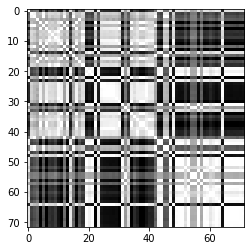

In [12]:
plt.imshow(M, cmap = 'gray')

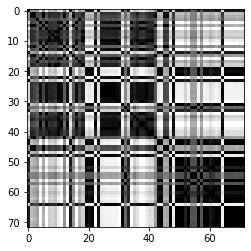

In [13]:
plt.imshow(1-M, cmap = 'gray')

#Final clustering can be achieved using 1-M as a distance matrix!

In [14]:
import scipy.spatial.distance as ssd
# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(1-M) # 

In [15]:
cells = df.columns.values

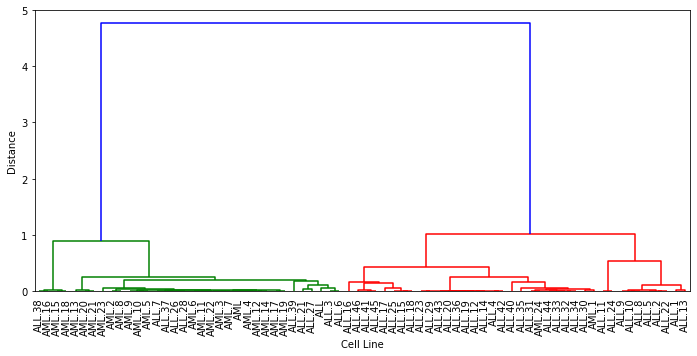

In [45]:
Z, den = make_dendogram(distArray, cells, 'ward', 'euclidean')

In [56]:
predicted_clusters = {den['ivl'][i]: cut_tree(Z,2)[i][0] for i in range(len(cut_tree(Z,2)))}

In [18]:
#need to determine the ordering of the clusters!

In [59]:
predicted_clusters

{'ALL.38': 0,
 'AML.16': 1,
 'AML.15': 1,
 'AML.18': 1,
 'AML.13': 1,
 'AML.20': 1,
 'AML.21': 1,
 'AML.23': 1,
 'AML.2': 1,
 'AML.8': 1,
 'AML.9': 1,
 'AML.10': 1,
 'AML.5': 1,
 'ALL.7': 1,
 'ALL.37': 0,
 'ALL.26': 1,
 'ALL.28': 1,
 'AML.6': 1,
 'AML.11': 1,
 'AML.22': 0,
 'AML.3': 0,
 'AML.7': 0,
 'AML': 1,
 'AML.4': 0,
 'AML.12': 1,
 'AML.14': 1,
 'AML.17': 1,
 'AML.19': 1,
 'ALL.39': 1,
 'ALL.21': 1,
 'ALL.27': 1,
 'ALL': 0,
 'ALL.3': 0,
 'ALL.6': 0,
 'ALL.16': 1,
 'ALL.46': 1,
 'ALL.41': 1,
 'ALL.45': 1,
 'ALL.17': 1,
 'ALL.25': 1,
 'ALL.15': 1,
 'ALL.18': 1,
 'ALL.23': 1,
 'ALL.29': 0,
 'ALL.43': 0,
 'ALL.20': 1,
 'ALL.36': 1,
 'ALL.19': 0,
 'ALL.12': 1,
 'ALL.14': 0,
 'ALL.4': 0,
 'ALL.42': 0,
 'ALL.40': 0,
 'ALL.35': 0,
 'ALL.31': 0,
 'AML.24': 0,
 'ALL.44': 0,
 'ALL.33': 0,
 'ALL.32': 0,
 'ALL.34': 0,
 'ALL.30': 0,
 'AML.1': 0,
 'ALL.11': 0,
 'ALL.24': 0,
 'ALL.9': 1,
 'ALL.10': 0,
 'ALL.8': 0,
 'ALL.5': 0,
 'ALL.2': 0,
 'ALL.22': 0,
 'ALL.1': 0,
 'ALL.13': 0}

## Purity:
Purity is a measure of the extent to which clusters contain a single class. Its calculation can be thought of as follows: For each cluster, count the number of data points from the most common class in said cluster. Now take the sum over all clusters and divide by the total number of data points. 

This measure doesn't penalize having many clusters. So for example, a purity score of 1 is possible by putting each data point in its own cluster. Also purity doesn't work well for imbalanced data: if a size 1000 dataset consists of two classes, one class contains 999 points and the other has only 1 point. No matter how bad a clustering algorithm performs, it will always give a very high purity value.

## Rand Index 


In [36]:
def rand_index(labels_A,labels_B):
    """
    labels_A and labels_B are two lists of item labels partitioning a set
    of items. The types of the labels are arbitrary and do not have to be
    consistent. The Rand index calculates the fraction of item pairs that
    are consistently labeled in both partitions
    >>> rand_index([1,1,2,2],['a','b','a','b'])
    0.3333333333333333
    >>> rand_index([int,int,int,float,float],[dict,set,set,set,set])
    0.4
    >>> rand_index([1,2,2,3,3,3,4,4,4,4],[4,3,3,2,2,2,1,1,1,1])
    1.0
    """
    assert len(labels_A) == len(labels_B)
    n = len(labels_A)
    total = n*(n-1)/2 # total number of pairs
    consistent = 0
    for i,j in itertools.combinations(range(n),2):
        # Check for consistent assignment
        if (labels_A[i]==labels_A[j]) == (labels_B[i]==labels_B[j]):
            consistent += 1
    return consistent/total

In [60]:
sorted_predictions = [ predicted_clusters[x] for x in df.columns]
actual = [0 if 'ALL' in x else 1 for x in df.columns]

In [63]:
rand_index(sorted_predictions, actual)

0.5402973395931142

In [62]:
import itertools

In [19]:
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


In [20]:
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=42)
W = model.fit_transform(df)
H = model.components_


In [21]:
model.get_params()

{'alpha': 0.0,
 'beta_loss': 'frobenius',
 'init': 'random',
 'l1_ratio': 0.0,
 'max_iter': 200,
 'n_components': 2,
 'random_state': 42,
 'shuffle': False,
 'solver': 'cd',
 'tol': 0.0001,
 'verbose': 0}

l1_ratio == 0 implies that the l2 value is 1 and the penalty is only the Frobenious norm that introduces sparsity.

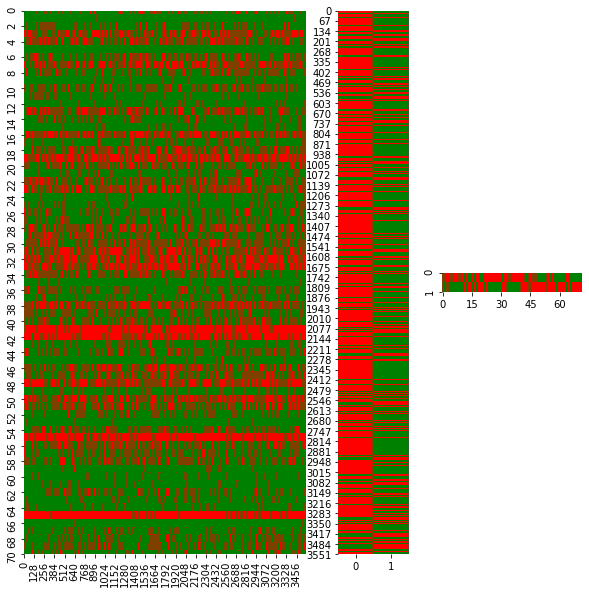

In [22]:
fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios':[2,0.5,1]}, figsize = (10,10))
ax = ax.ravel() 
ax[2].set_aspect(10)
ax[0] = sns.heatmap(df.transpose(), cmap = ['green', 'red'], ax = ax[0], cbar = False)
ax[1] = sns.heatmap(W, cmap = ['green', 'red'], ax = ax[1], cbar = False)
ax[2] = sns.heatmap(H, cmap = ['green', 'red'], ax= ax[2], cbar = False)
plt.show()

 The samples need to be reordered in order to better show the class distributions

In [23]:
#better representation if we sort the columns according to column name!

Text(0, 0.5, 'meta gene expression profile!')

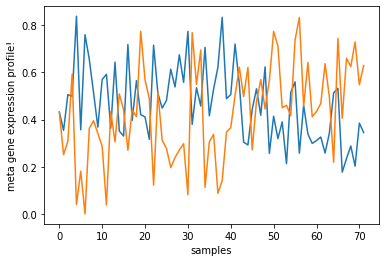

In [24]:
plt.plot(range(72), H[0])
plt.plot(range(72), H[1])
plt.xlabel('samples')

plt.ylabel('meta gene expression profile!')


The relative amplitudes of the two metagenes determine two classes of samples, class 1 and class 2. 

Text(0, 0.5, 'meta gene expression profile!')

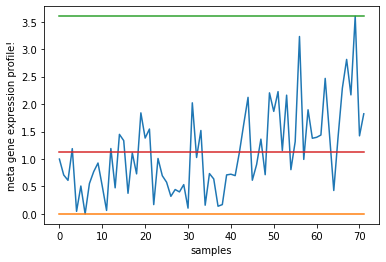

In [25]:
plt.plot(range(72), H[1]/H[0])
plt.plot(range(72), [min(H[1]/H[0]) for x in H[1]/H[0]])
plt.plot(range(72), [max(H[1]/H[0]) for x in H[1]/H[0]])
plt.plot(range(72), [sum(H[1]/H[0])/72 for x in H[1]/H[0]])
plt.xlabel('samples')
plt.ylabel('meta gene expression profile!')
#Higher means class 1, lowe means class 0 


In [26]:
matrix = [x/y if y!=0 else x for x,y in zip(H[1],H[0])]
avg_expr = sum(matrix)/72

In [27]:
classes_nmf = np.array([1 if x>avg_expr else 0 for x in matrix])

Implies 47 are ALL and rest are AML so till index 47 is class 1 <br> 
and later is class 2 i.e. AML

From the original paper: https://www.pnas.org/content/101/12/4164 <br>  
    For each run, the sample assignment can be defined by a connectivity matrix C of size M × M, with entry cij = 1 if samples i and j belong to the same cluster, and cij = 0 if they belong to different clusters. We can then compute the consensus matrix, C̄, defined as the average connectivity matrix over many clustering runs. 
    

In [28]:
C = np.zeros((len(df.columns), len(df.columns)))

In [29]:
for i in range(len(classes_nmf)): 
    for j in range(len(classes_nmf)):
        if classes_nmf[i] == classes_nmf[j]: 
             C[i][j] = 1

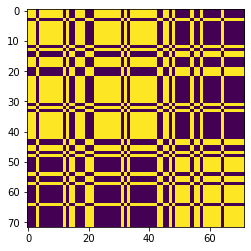

In [30]:
plt.imshow(C)

In [31]:
# This whole process can be done 50 times to get K=2 avg clustering!

In [32]:
def iterate_nmf(df, iterations): 
    C_total = np.zeros((len(df.columns), len(df.columns)))
    for i in range(iterations): 
        model = NMF(n_components=2, init='random', random_state=i)
        W = model.fit_transform(df)
        H = model.components_
        matrix = [x/y if y!=0 else x for x,y in zip(H[1],H[0])] #relative expression
        avg_expr = sum(matrix)/72
        classes_nmf = np.array([1 if x>avg_expr else 0 for x in matrix])
        C = np.zeros((len(df.columns), len(df.columns)))
        for i in range(len(classes_nmf)): 
            for j in range(len(classes_nmf)):
                    if classes_nmf[i] == classes_nmf[j]: 
                         C[i][j] = 1
        C_total += C
    return C_total/iterations


In [33]:
C_total = iterate_nmf(df,50)

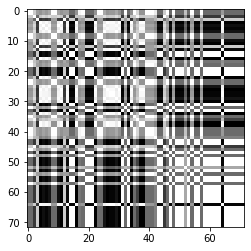

In [34]:
plt.imshow(C_total, cmap = 'gray')